In [166]:
#*********************@Author: Aniruddh Khera*********************
# About the data: S&P500 companies stock prices from 2010-2016
# Here I analyzed for GOOGLE, we can do it for other, by automating the prcoess using grid search on best t-stats value
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb  
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("prices-split-adjusted.csv")

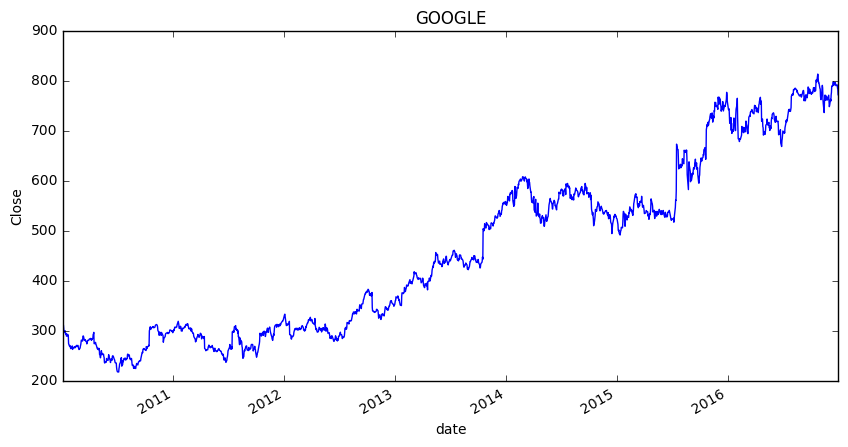

In [167]:
#**********************EXPLORATORY ANALYSIS**********************
#select google
goog = df[df.symbol == 'GOOG']
goog.date = goog.date.convert_objects(convert_dates='coerce')
goog = goog.sort_index(by="date")
goog = goog.set_index("date")
goog['close'].plot(figsize=(10,5), title="GOOGLE").set_ylabel("Close")

In [168]:
# Split data into training & testing
goog_train = goog[goog.index<'2016-12-01']
goog_test = goog[goog.index>='2016-12-01']

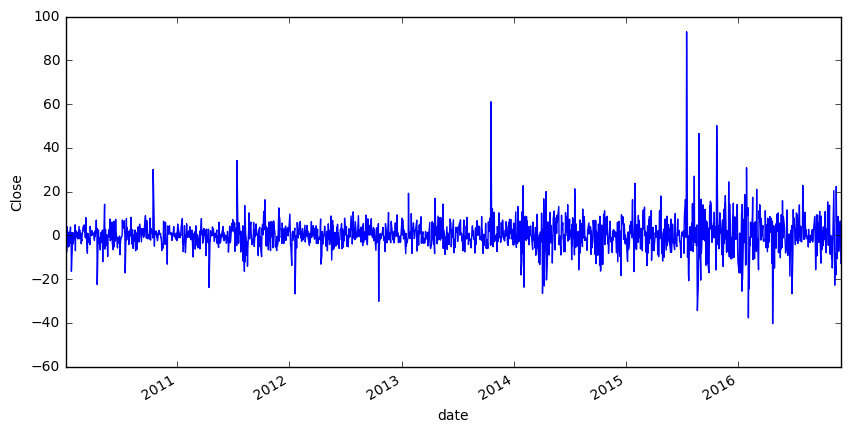

In [169]:
# Clearly unstationary 
# Take 1st difference
goog_train['First Difference'] = goog_train['close'] - goog_train['close'].shift()  
goog_train['First Difference'].plot(figsize=(10, 5)).set_ylabel("Close")  

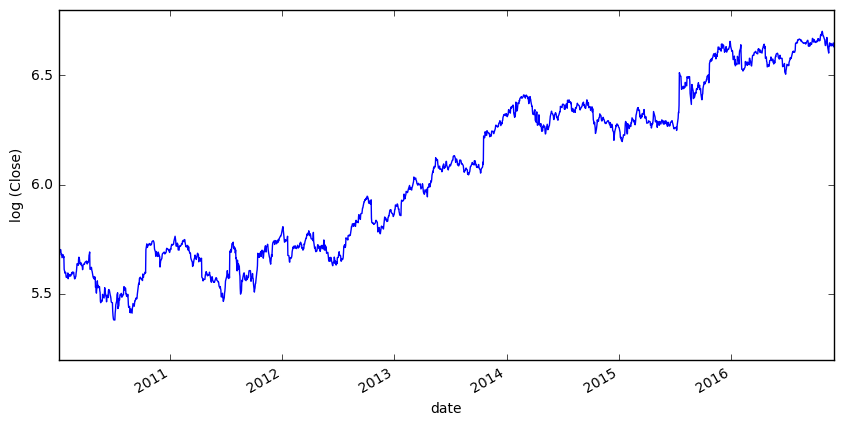

In [170]:
# Exponential smoothing by taking log to make variance constant
goog_train['Natural Log'] = goog_train['close'].apply(lambda x: np.log(x))  
goog_train['Natural Log'].plot(figsize=(10, 5)).set_ylabel("log (Close)") 

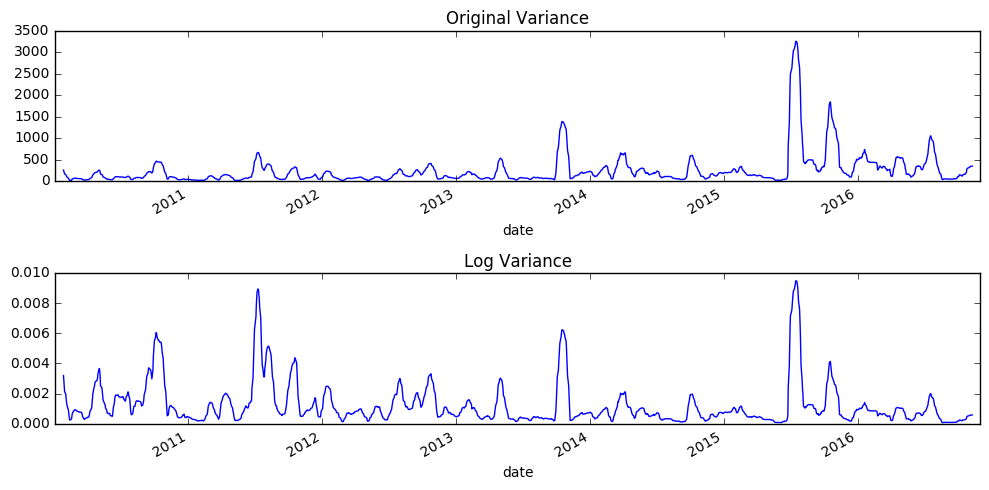

In [171]:
goog_train['Original Variance'] = pd.rolling_var(goog_train['close'], 30, min_periods=None, freq=None, center=True)  
goog_train['Log Variance'] = pd.rolling_var(goog_train['Natural Log'], 30, min_periods=None, freq=None, center=True)

fig, ax = plt.subplots(2, 1, figsize=(10, 5))  
goog_train['Original Variance'].plot(ax=ax[0], title='Original Variance')  
goog_train['Log Variance'].plot(ax=ax[1], title='Log Variance')  
fig.tight_layout()  

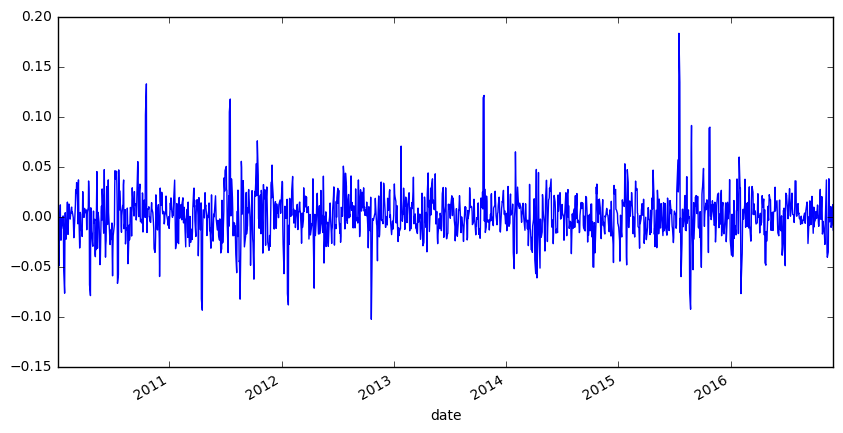

In [172]:
# goog_train['Logged First Difference'] = goog_train['Natural Log'] - goog_train['Natural Log'].shift()  
#goog_train['Logged First Difference'].plot(figsize=(10, 5))  
# goog_train['Logged First Difference'].dropna(inplace=True)
goog_train['Logged Second Difference'] = goog_train['Natural Log'] - goog_train['Natural Log'].shift(2)  
goog_train['Logged Second Difference'].plot(figsize=(10, 5))  
goog_train['Logged Second Difference'].dropna(inplace=True)

Results of Dickey-Fuller Test:
Test Statistic                -9.520291e+00
p-value                        3.077834e-16
#Lags Used                     2.300000e+01
Number of Observations Used    1.715000e+03
Critical Value (1%)           -3.434169e+00
Critical Value (10%)          -2.567668e+00
Critical Value (5%)           -2.863227e+00
dtype: float64


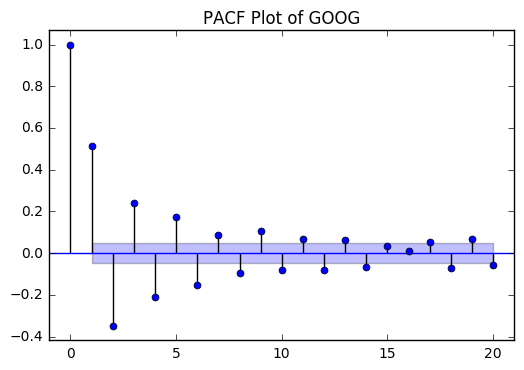

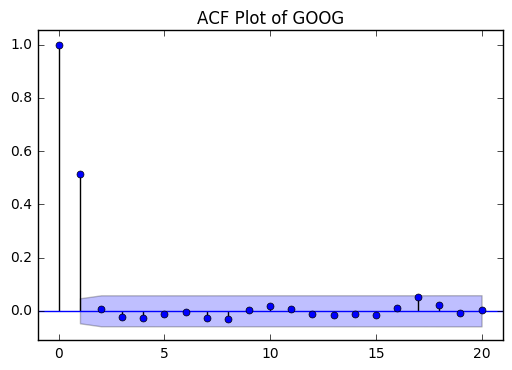

In [173]:
#Perform Dickey-Fuller test: To get the right difference based on AIC values. We get the best value 2
print('Results of Dickey-Fuller Test:')
dftest = adfuller(goog_train['Logged Second Difference'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
    
pacf = plot_pacf(goog_train['Logged Second Difference'],lags=20)
plt.title("PACF Plot of GOOG")

acf = plot_acf(goog_train['Logged Second Difference'], lags=20)
plt.title("ACF Plot of GOOG")

            
            

                             ARIMA Model Results                              
Dep. Variable:         D2.Natural Log   No. Observations:                 1739
Model:                 ARIMA(1, 2, 0)   Log Likelihood                4418.270
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sun, 26 Nov 2017   AIC                          -8830.539
Time:                        19:10:06   BIC                          -8814.156
Sample:                    01-06-2010   HQIC                         -8824.481
                         - 11-30-2016                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.554e-07      0.000      0.002      0.998      -0.001       0.001
ar.L1.D2.Natural Log    -0.4949      0.021    -23.749      0.000      -0.536      -0.454
            

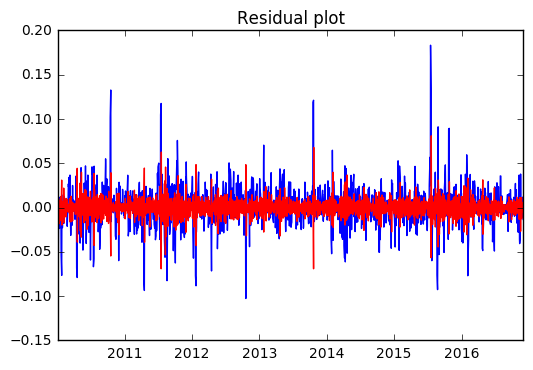

In [174]:
# AR Model
model = ARIMA(goog_train['Natural Log'], order=(1, 2, 0))  
results_AR = model.fit(disp=1)  
plt.plot(goog_train['Logged Second Difference'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title( "Residual plot")
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:         D2.Natural Log   No. Observations:                 1739
Model:                 ARIMA(0, 2, 1)   Log Likelihood                4753.308
Method:                       css-mle   S.D. of innovations              0.016
Date:                Sun, 26 Nov 2017   AIC                          -9500.617
Time:                        19:10:06   BIC                          -9484.233
Sample:                    01-06-2010   HQIC                         -9494.558
                         - 11-30-2016                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 8.447e-07   2.49e-06      0.340      0.734   -4.03e-06    5.72e-06
ma.L1.D2.Natural Log    -0.9944      0.012    -83.817      0.000      -1.018      -0.971
            

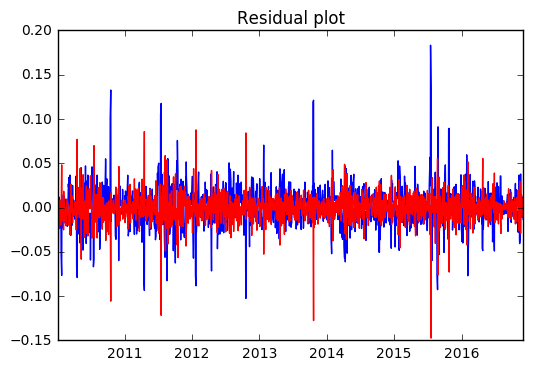

In [175]:
# MA Model
model = ARIMA(goog_train['Natural Log'], order=(0, 2, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(goog_train['Logged Second Difference'])
plt.plot(results_MA.fittedvalues, color='red')
plt.title("Residual plot")
print(results_MA.summary())

                             ARIMA Model Results                              
Dep. Variable:         D2.Natural Log   No. Observations:                 1739
Model:                 ARIMA(1, 2, 1)   Log Likelihood                4755.193
Method:                       css-mle   S.D. of innovations              0.016
Date:                Sun, 26 Nov 2017   AIC                          -9502.387
Time:                        19:10:07   BIC                          -9480.543
Sample:                    01-06-2010   HQIC                         -9494.309
                         - 11-30-2016                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.583e-07   9.23e-07      0.605      0.545   -1.25e-06    2.37e-06
ar.L1.D2.Natural Log     0.0404      0.024      1.682      0.093      -0.007       0.087
ma.L1.D2.Nat

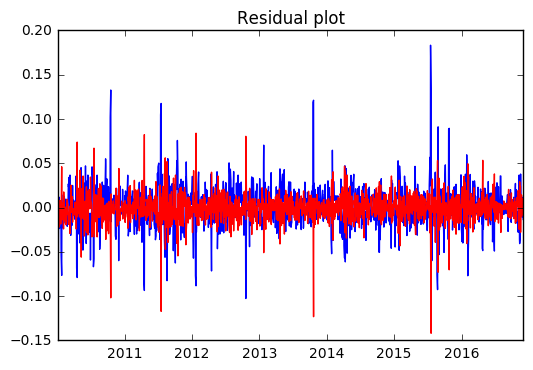

In [176]:
# ARIMA Model
model = ARIMA(goog_train['Natural Log'], order=(1, 2, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(goog_train['Logged Second Difference'])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title("Residual plot")
print(results_ARIMA.summary())

In [177]:
# Take back to original scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
# print (predictions_ARIMA_diff.head(10))
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(goog_train['Natural Log'].ix[0], index=goog_train['Natural Log'].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head(10)

date
2010-01-04    5.743661
2010-01-05    5.743661
2010-01-06    5.743662
2010-01-07    5.753795
2010-01-08    5.759388
2010-01-11    5.737309
2010-01-12    5.730831
2010-01-13    5.738405
2010-01-14    5.735019
2010-01-15    5.723319
dtype: float64

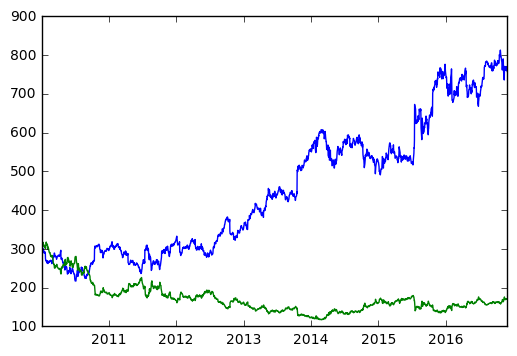

In [178]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(goog_train['close'])
plt.plot(predictions_ARIMA)

AttributeError: Unknown property start

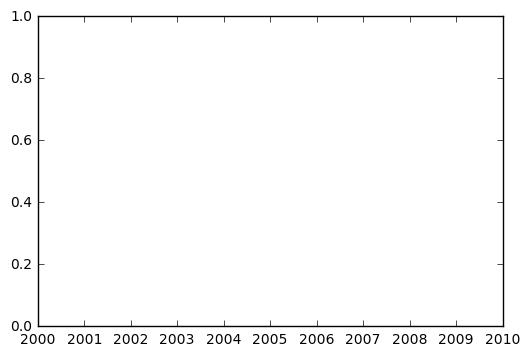

In [179]:
plt.plot(predictions_ARIMA, start='2016-12-01', end='2016-12-30')